In [1]:
import numpy as np
import csv
import os
import sklearn
import pandas
from pandas import read_csv as read
from sklearn import svm, preprocessing, ensemble
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from scipy.spatial import distance
import heapq
import matplotlib.pyplot as plt

In [2]:
path_train = "lab2data/arcene_train.data"
data_train = read(path_train, delimiter=" ")
data_train.columns = [i for i in range(1, 10001)] + ['class']
data_train = data_train.drop(['class'], axis=1)
#data_train.head()

In [3]:
path_test = "lab2data/arcene_valid.data"
data_test = read(path_test, delimiter=" ")
data_test.columns = [i for i in range(1, 10001)] + ['class']
data_test = data_test.drop(['class'], axis=1)
#data_test.head()

In [4]:
path_train_l = "lab2data/arcene_train.labels"
data_train_l = read(path_train_l, delimiter=" ")
path_test_l = "lab2data/arcene_valid.labels"
data_test_l = read(path_test_l, delimiter=" ")

In [5]:
X_train, X_test, y_train, y_test = data_train, data_test, np.ravel(data_train_l), np.ravel(data_test_l)

# Base result

In [6]:
rf = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf.fit(X_train, y_train)
base_score = rf.score(X_test, y_test)
print(base_score)

0.7373737373737373


# Filter1 feature importance

In [7]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]

print("Feature importances:")
for f, idx in enumerate(indices[:20]):
    print("{:2d}. feature '{:5d}' ({:.4f})".format(f + 1, X_train.columns[idx], importances[idx]))

Feature importances:
 1. feature ' 7542' (0.0118)
 2. feature ' 6307' (0.0067)
 3. feature ' 1184' (0.0067)
 4. feature ' 5473' (0.0064)
 5. feature ' 4554' (0.0058)
 6. feature '  414' (0.0054)
 7. feature ' 6774' (0.0054)
 8. feature ' 1411' (0.0053)
 9. feature ' 5005' (0.0051)
10. feature ' 9970' (0.0046)
11. feature ' 6928' (0.0043)
12. feature ' 6481' (0.0042)
13. feature ' 9408' (0.0040)
14. feature ' 7593' (0.0040)
15. feature ' 4960' (0.0040)
16. feature '  294' (0.0040)
17. feature ' 7101' (0.0040)
18. feature ' 2401' (0.0040)
19. feature ' 8540' (0.0039)
20. feature '  436' (0.0039)


In [8]:
best_features = indices[:135]
best_features_names = X_train.columns[best_features]
best_f = [int(i) for i in best_features_names]
#print(best_f)

In [9]:
#print(X_train[best_f])

In [10]:
rf2 = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
rf2.fit(X_train[best_f], y_train)
future_importance_score = rf2.score(X_test[best_f], y_test)
print(future_importance_score)

0.7474747474747475


# Filter2 euclidean distance

In [11]:
# normalize the data attributes
normalized_X = preprocessing.normalize(X_train)

rf4 = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)

dst_array = []

for i in range(0, 10000):
    dst_array.append(distance.euclidean(normalized_X[:,i], y_train))
dst_array = np.asarray(dst_array)
ind = heapq.nsmallest(20, range(len(dst_array)), dst_array.take)

rf4.fit(X_train[ind], y_train)
euclidean_score = rf4.score(X_test[ind], y_test)
print(euclidean_score)

0.8080808080808081


# Filter 3 coefficient correlation

In [12]:
rf5 = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
normalized_X = preprocessing.normalize(X_train)

corr_array = []

for i in range(0, 10000):
    corr_array.append(np.corrcoef(normalized_X[:,i], y_train)[0, 1])
corr_array = np.asarray(corr_array)
ind2 = heapq.nlargest(45, range(len(corr_array)), corr_array.take)

rf4.fit(X_train[ind2], y_train)
coef_corr_score = rf4.score(X_test[ind2], y_test)
print(coef_corr_score)

e:\prgfiles\miniconda3\lib\site-packages\numpy\lib\function_base.py:2400: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
e:\prgfiles\miniconda3\lib\site-packages\numpy\lib\function_base.py:2401: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


0.8282828282828283


# Wrapper

In [19]:
import random
rf3 = ensemble.RandomForestClassifier(n_estimators=100, random_state=11)
c = list(range(1, 10001))
c = random.sample(c, 10000)
g = random.sample(c, 10)
rf_fit = rf3.fit(X_train[g], y_train)
wrapper_score = rf_fit.score(X_test[g], y_test)
for i in range(1, 10001):          #Forward Selection wrapper
    if c[i] in g:
        continue
    g.append(c[i])
    fit = rf_fit.fit(X_train[g], y_train)
    score = rf_fit.score(X_test[g], y_test)
    if score < wrapper_score:
        break
    wrapper_score = score
print(wrapper_score)

0.7575757575757576


# Plot

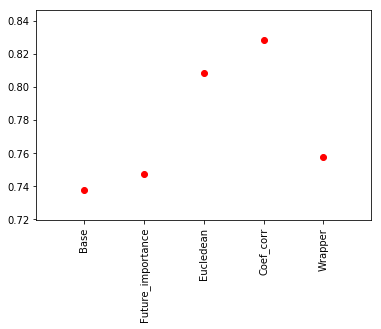

In [20]:
x = [1, 2, 3, 4, 5]
y = [base_score, future_importance_score, euclidean_score, coef_corr_score, wrapper_score]
labels = ['Base', 'Future_importance', 'Eucledean', 'Coef_corr', 'Wrapper']

plt.plot(x, y, 'ro')
# You can specify a rotation for the tick labels in degrees or with keywords.
plt.xticks(x, labels, rotation='vertical')
# Pad margins so that markers don't get clipped by the axes
plt.margins(0.2)
# Tweak spacing to prevent clipping of tick-labels
plt.subplots_adjust(bottom=0.15)
plt.show()